# 1) Imports and Environment Setup

In [1]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks/EDS6397-NLP/Final Project')

Mounted at /content/gdrive


In [3]:
# import libaries
!pip install torch==1.12.1 torchvision==0.13.1 torchaudio==0.12.1 --index-url https://download.pytorch.org/whl/cu113
!pip install transformers

import time
import transformers
from transformers import AlbertTokenizerFast, AlbertModel, AlbertForQuestionAnswering
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

Looking in indexes: https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 769.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 2.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu121
    Uninstalling torch-2.5.1+cu121:
      Successfully uninstalled torch-2.5.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.1+cu121
    Uninstalling torchvision-0.20.1+cu121:
      Successfully uninstalled torchvision-0.20.1+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.5.1+cu121
    Uninstalling torchaudio-2.5.1+cu121:
      Successfully uninstalled torchaudio-2.5.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depe

In [4]:
# check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 2) Load and Preprocess Data

In [5]:
# load data
import json

with open('train-v2.0.json', 'r') as f:
  squad_data = json.load(f)

with open('dev-v2.0.json', 'r') as f:
  squad_dev = json.load(f)

In [6]:
# load tokenizer
tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [7]:
def preprocess_squad(squad_data, tokenizer, max_length=512):
  inputs = []
  targets = []
  data_info = {"context_lengths":[], "question_lengths":[], "answerable_counts":{"answerable": 0, "unanswerable":0}}

  for article in squad_data['data']:

    for paragraph in article['paragraphs']:
      context = paragraph['context']
      context_length = len(context.split())
      data_info["context_lengths"].append(context_length)

      for qa in paragraph['qas']:
        question = qa['question']
        question_length = len(question.split())
        data_info["question_lengths"].append(question_length)

        if qa['is_impossible']:
          #handle unanswerable questions
          data_info["answerable_counts"]["unanswerable"] += 1
          inputs.append(tokenizer.encode_plus(question, context, max_length=max_length, truncation=True, padding="max_length", return_tensors="pt"))
          targets.append({"start":-1,"end":-1}) #mark as unanswerable

        else:
          #handle answerable questions
          data_info["answerable_counts"]["answerable"] += 1
          answer_text = qa['answers'][0]['text']
          answer_start = qa['answers'][0]['answer_start']
          answer_end = answer_start + len(answer_text)

          #tokenize context and question
          encoded = tokenizer.encode_plus(question, context, max_length=max_length, truncation=True, padding="max_length", return_offsets_mapping=True, return_tensors="pt")

          #map answer span to token positions
          offset_mapping = encoded["offset_mapping"][0].numpy()
          start_position = -1
          end_position = -1
          for idx, (start, end) in enumerate(offset_mapping):
            if start == answer_start:
              start_position = idx
            if end == answer_end:
              end_position = idx
          if start_position == -1 or end_position == -1:
            continue #skip if span cannot be found

          inputs.append(encoded)
          targets.append({"start":start_position, "end":end_position})
  return inputs, targets, data_info

#preprocess the dataset
inputs, targets, data_info = preprocess_squad(squad_data, tokenizer)

#split the data into training and testing (80% training and 20% testing)
train_val_inputs, test_inputs, train_val_targets, test_targets = train_test_split(inputs, targets, test_size=0.2, random_state=42)

#split the training data into training and evaluation (64% training, 16% evaluation, and 20% testing)
train_inputs, val_inputs, train_targets, val_targets = train_test_split(train_val_inputs, train_val_targets, test_size=0.2, random_state=42)

# Print sizes to verify
print(f"Training data size: {len(train_inputs)}")
print(f"Validation data size: {len(val_inputs)}")
print(f"Testing data size: {len(test_inputs)}")

Training data size: 83214
Validation data size: 20804
Testing data size: 26005


# 3) Dataset, DataLoader and Data Visualization

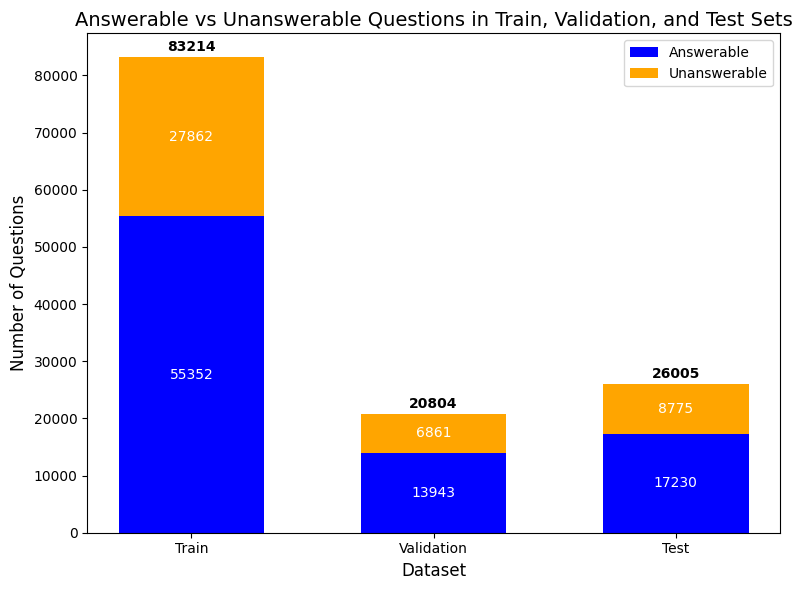

In [8]:
from functools import total_ordering
import matplotlib.pyplot as plt

# Function to count answerable and unanswerable questions
def count_questions(inputs, targets):
    answerable = 0
    unanswerable = 0
    for target in targets:
        if target['start'] == -1 and target['end'] == -1:
            unanswerable += 1
        else:
            answerable += 1
    return {"answerable": answerable, "unanswerable": unanswerable}

# Count questions in each dataset
train_counts = count_questions(train_inputs, train_targets)
val_counts = count_questions(val_inputs, val_targets)
test_counts = count_questions(test_inputs, test_targets)

# Data for the bar plot
labels = ['Train', 'Validation', 'Test']
answerable_counts = [train_counts['answerable'], val_counts['answerable'], test_counts['answerable']]
unanswerable_counts = [train_counts['unanswerable'], val_counts['unanswerable'], test_counts['unanswerable']]
total_counts = [answerable_counts[i] + unanswerable_counts[i] for i in range(len(labels))]

# Plot the bar plot
x = range(len(labels))
width = 0.6

fig, ax = plt.subplots(figsize=(8, 6))

bars1 = ax.bar(x, answerable_counts, width, label='Answerable', color='blue')
bars2 = ax.bar(x, unanswerable_counts, width, bottom=answerable_counts, label='Unanswerable', color='orange')

# Add annotations on the bars
for i in range(len(labels)):
    # Annotate answerable counts
    ax.text(x[i], answerable_counts[i] / 2, str(answerable_counts[i]), ha='center', va='center', color='white', fontsize=10)
    # Annotate unanswerable counts
    ax.text(x[i], answerable_counts[i] + (unanswerable_counts[i] / 2), str(unanswerable_counts[i]), ha='center', va='center', color='white', fontsize=10)
    # Annotate total counts
    ax.text(x[i], answerable_counts[i] + unanswerable_counts[i] + 500, str(total_counts[i]), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add labels and title
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Number of Questions', fontsize=12)
ax.set_title('Answerable vs Unanswerable Questions in Train, Validation, and Test Sets', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

In [9]:
class SquadDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_data = self.inputs[idx]
        target_data = self.targets[idx]
        return {
            "input_ids": input_data["input_ids"].squeeze(0),
            "attention_mask": input_data["attention_mask"].squeeze(0),
            "token_type_ids": input_data["token_type_ids"].squeeze(0),
            "start_positions": torch.tensor(target_data["start"]),
            "end_positions": torch.tensor(target_data["end"]),
        }

# Create DataLoaders
from torch.utils.data import DataLoader

train_dataset = SquadDataset(train_inputs, train_targets)
val_dataset = SquadDataset(val_inputs, val_targets)
test_dataset = SquadDataset(test_inputs, test_targets)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [10]:
def count_parameters(model):
    total_params = 0
    trainable_params = 0
    total_weights = 0
    total_biases = 0

    for name, param in model.named_parameters():
        param_count = param.numel()  # Number of elements in the tensor

        # Count total parameters
        total_params += param_count

        # Count trainable parameters
        if param.requires_grad:
            trainable_params += param_count

        # Check if it's a weight or bias parameter
        if "weight" in name:
            total_weights += param_count
        elif "bias" in name:
            total_biases += param_count

    print(f"Total Parameters: {total_params}")
    print(f"Trainable Parameters: {trainable_params}")
    print(f"Total Weights: {total_weights}")
    print(f"Total Biases: {total_biases}")

    return {
        "total_params": total_params,
        "trainable_params": trainable_params,
        "weights": total_weights,
        "biases": total_biases,
    }

# 4) Model Initialization

In [11]:
# Load pre-trained model
model = AlbertForQuestionAnswering.from_pretrained('albert-base-v2')

# Get the model configuration
config = model.config

# Print model details
print(f"Model: ALBERT-base-v2")
print(f"Number of encoder layers (L): {config.num_hidden_layers}")
print(f"Number of hidden layers (H): {config.hidden_size}")
print(f"Vocabulary embedding size (E): {config.embedding_size}")
print(f"Number of attention heads: {config.num_attention_heads}")
print(f"Vocabulary size: {config.vocab_size}")
print(f"Intermediate size (Feedforward/filter size): {config.intermediate_size}")
print(f"Maximum Sequence Length: {config.max_position_embeddings}")


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForQuestionAnswering were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: ALBERT-base-v2
Number of encoder layers (L): 12
Number of hidden layers (H): 768
Vocabulary embedding size (E): 128
Number of attention heads: 12
Vocabulary size: 30000
Intermediate size (Feedforward/filter size): 3072
Maximum Sequence Length: 512


In [12]:
from itertools import count
# Freeze all Transformer weights explicitly
for name, param in model.named_parameters():
    # Unfreeze only the QA outputs
    if "qa_outputs" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Get parameter counts
count = count_parameters(model)['total_params'] - count_parameters(model)['trainable_params']
print(f"Total Frozen Parameters: {count}")

Total Parameters: 11094530
Trainable Parameters: 1538
Total Weights: 11085184
Total Biases: 9346
Total Parameters: 11094530
Trainable Parameters: 1538
Total Weights: 11085184
Total Biases: 9346
Total Frozen Parameters: 11092992


# 5) Define Training and Evaluation Functions

In [14]:
model.to(device)
import time
from torch.nn.utils import clip_grad_norm_
from sklearn.metrics import precision_score, recall_score, f1_score

# Utility Functions
def compute_metrics(true_positions, pred_positions):
    """Compute Precision, Recall, F1-Score, and Exact Match."""
    precision = precision_score(true_positions, pred_positions, average='micro')
    recall = recall_score(true_positions, pred_positions, average='micro')
    f1 = f1_score(true_positions, pred_positions, average='micro')
    exact_match = sum([1 for true, pred in zip(true_positions, pred_positions) if true == pred]) / len(true_positions)
    return precision, recall, f1, exact_match

def process_batch(batch, device):
    """Move batch data to the appropriate device."""
    return (
        batch["input_ids"].to(device),
        batch["attention_mask"].to(device),
        batch["token_type_ids"].to(device),
        batch["start_positions"].to(device),
        batch["end_positions"].to(device),
    )

# Core Functions
def run_epoch(model, data_loader, optimizer=None, scheduler=None, is_training=True):
    """Run a single epoch of training or evaluation."""
    model.train() if is_training else model.eval()
    total_loss = 0
    all_true_start, all_pred_start, all_true_end, all_pred_end = [], [], [], []

    start_time = time.time()  # Start timing the epoch

    for batch in data_loader:
        input_ids, attention_mask, token_type_ids, start_positions, end_positions = process_batch(batch, device)

        if is_training:
            optimizer.zero_grad()

        with torch.set_grad_enabled(is_training):
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                start_positions=start_positions,
                end_positions=end_positions,
            )
            loss = outputs.loss
            if is_training:
                loss.backward()
                clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                if scheduler:
                    scheduler.step()

        total_loss += loss.item()
        pred_start = torch.argmax(outputs.start_logits, dim=-1).cpu().numpy()
        pred_end = torch.argmax(outputs.end_logits, dim=-1).cpu().numpy()

        all_true_start.extend(start_positions.cpu().numpy())
        all_pred_start.extend(pred_start)
        all_true_end.extend(end_positions.cpu().numpy())
        all_pred_end.extend(pred_end)

    end_time = time.time()  # End timing the epoch

    avg_loss = total_loss / len(data_loader)
    metrics_start = compute_metrics(all_true_start, all_pred_start)
    metrics_end = compute_metrics(all_true_end, all_pred_end)
    epoch_time = end_time - start_time

    print(f"Time taken for epoch: {epoch_time:.2f} seconds")
    return avg_loss, metrics_start, metrics_end, epoch_time

def train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler, epochs):
    """Train and evaluate the model across epochs."""
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Track training time
        train_loss, train_start_metrics, train_end_metrics, train_time = run_epoch(
            model, train_loader, optimizer, scheduler, is_training=True
        )
        print(f"Training Loss: {train_loss:.4f}")
        print(f"Training Time: {train_time:.2f} seconds")
        print(f"Start Metrics (Train): {train_start_metrics}")
        print(f"End Metrics (Train): {train_end_metrics}")

        # Track validation time
        val_loss, val_start_metrics, val_end_metrics, val_time = run_epoch(
            model, val_loader, is_training=False
        )
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Time: {val_time:.2f} seconds")
        print(f"Start Metrics (Validation): {val_start_metrics}")
        print(f"End Metrics (Validation): {val_end_metrics}")

    print("Training and evaluation complete.")

def test_model(model, test_loader):
    """Test the model and track testing time."""
    print("Testing the model...")
    start_time = time.time()
    test_loss, test_start_metrics, test_end_metrics, test_time = run_epoch(
        model, test_loader, is_training=False
    )
    print(f"Testing Loss: {test_loss:.4f}")
    print(f"Testing Time: {test_time:.2f} seconds")
    print(f"Start Metrics (Test): {test_start_metrics}")
    print(f"End Metrics (Test): {test_end_metrics}")
    return test_loss, test_start_metrics, test_end_metrics, test_time

# ALBERT 1

## 6) Training Loop

In [13]:
# Set hyperparameters
learning_rate = 3e-5
epochs = 3
batch_size = 16
num_training_steps = len(train_loader) * epochs
warmup_steps = int(0.1 * num_training_steps)  # 10% of total steps for warmup

# Define Optimizer and Scheduler
from transformers import AdamW
from transformers import get_scheduler

optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_training_steps)

# Print details
print(f"Number of training steps: {num_training_steps}")
print(f"Warmup steps: {warmup_steps}")

Number of training steps: 15603
Warmup steps: 1560


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler, epochs)

Epoch 1/3
Time taken for epoch: 767.46 seconds
Training Loss: 3.6691
Training Time: 767.46 seconds
Start Metrics (Train) - Precision: 0.0034, Recall: 0.0034, F1: 0.0034, EM: 0.0034
End Metrics (Train) - Precision: 0.0023, Recall: 0.0023, F1: 0.0023, EM: 0.0023
Time taken for epoch: 189.34 seconds
Validation Loss: 3.0408
Validation Time: 189.34 seconds
Start Metrics (Validation) - Precision: 0.0110, Recall: 0.0110, F1: 0.0110, EM: 0.0110
End Metrics (Validation) - Precision: 0.0089, Recall: 0.0089, F1: 0.0089, EM: 0.0089
Epoch 2/3
Time taken for epoch: 767.29 seconds
Training Loss: 2.9430
Training Time: 767.29 seconds
Start Metrics (Train) - Precision: 0.0165, Recall: 0.0165, F1: 0.0165, EM: 0.0165
End Metrics (Train) - Precision: 0.0145, Recall: 0.0145, F1: 0.0145, EM: 0.0145
Time taken for epoch: 189.33 seconds
Validation Loss: 2.8856
Validation Time: 189.33 seconds
Start Metrics (Validation) - Precision: 0.0235, Recall: 0.0235, F1: 0.0235, EM: 0.0235
End Metrics (Validation) - Precis

## 7) Testing Loop

In [16]:
test_model(model, test_loader)

Testing the model...
Time taken for epoch: 236.48 seconds
Testing Loss: 2.8368
Testing Time: 236.48 seconds
Start Metrics (Test) - Precision: 0.0291, Recall: 0.0291, F1: 0.0291, EM: 0.0291
End Metrics (Test) - Precision: 0.0274, Recall: 0.0274, F1: 0.0274, EM: 0.0274


(2.8367950966144106,
 (0.029071332436069987,
  0.029071332436069987,
  0.029071332436069987,
  0.029071332436069987),
 (0.02741780426840992,
  0.02741780426840992,
  0.02741780426840992,
  0.02741780426840992),
 236.47696900367737)

# ALBERT 2

In [18]:
# Load pre-trained model
model2 = AlbertForQuestionAnswering.from_pretrained('albert-large-v2')
# load tokenizer
tokenizer = AlbertTokenizerFast.from_pretrained('albert-large-v2')

# Get the model configuration
config2 = model2.config

# Print model details
print(f"Model: ALBERT-base-v2")
print(f"Number of encoder layers (L): {config2.num_hidden_layers}")
print(f"Number of hidden layers (H): {config2.hidden_size}")
print(f"Vocabulary embedding size (E): {config2.embedding_size}")
print(f"Number of attention heads: {config2.num_attention_heads}")
print(f"Vocabulary size: {config2.vocab_size}")
print(f"Intermediate size (Feedforward/filter size): {config2.intermediate_size}")
print(f"Maximum Sequence Length: {config2.max_position_embeddings}")

Some weights of AlbertForQuestionAnswering were not initialized from the model checkpoint at albert-large-v2 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: ALBERT-base-v2
Number of encoder layers (L): 24
Number of hidden layers (H): 1024
Vocabulary embedding size (E): 128
Number of attention heads: 16
Vocabulary size: 30000
Intermediate size (Feedforward/filter size): 4096
Maximum Sequence Length: 512


## 6) Training Loop

In [ ]:
# Set hyperparameters
learning_rate = 2e-5
epochs = 3
batch_size = 8  # Reduced batch size for memory
gradient_accumulation_steps = 4
num_training_steps = len(train_loader) * epochs // gradient_accumulation_steps
warmup_steps = int(0.1 * num_training_steps)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_training_steps)

# FP16 Training
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()

# Print details
print(f"Number of training steps: {num_training_steps}")
print(f"Warmup steps: {warmup_steps}")

Number of training steps: 3900
Warmup steps: 390


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## 7) Testing Loop

# 8) Visualize Results

# ALBERT
* albert-base-v2 configuration
* Tokenizer: AlbertTokenizerFast
* Hugging face's tokenizer automatically adds [CLS] and [SEP] during encode_plus. No need for manual adding.
* Max sequence length: 512

* Training loop:
  * Loss function: hugging face model handles the loss calculation internally for start and end position
  * Optimizer: AdamW
  * Batch size: 16
  * Learning rate: 3e-5
  * Number of epochs: 1



## Training

In [ ]:
import time

#check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to train for one epoch
def train_epoch(model, train_loader, optimizer):
    model.train()
    total_loss = 0
    start_time = time.time()  # Record the start time

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        start_positions = batch["start_positions"].to(device)
        end_positions = batch["end_positions"].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            start_positions=start_positions,
            end_positions=end_positions,
        )
        loss = outputs.loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters
        total_loss += loss.item()

    end_time = time.time()  # Record the end time
    epoch_time = end_time - start_time  # Calculate epoch duration

    avg_loss = total_loss / len(train_loader)  # Average loss for the epoch
    print(f"Epoch Loss: {avg_loss:.4f}")
    print(f"Time taken for this epoch: {epoch_time:.2f} seconds\n")

    return avg_loss

Using device: cuda


In [ ]:
# Ensure model is on the correct device
model.to(device)

# Training loop
epochs = 1
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss = train_epoch(model, train_loader, optimizer)
    print(f"Epoch {epoch + 1} Completed, Average Loss: {train_loss:.4f}")

Epoch 1/1
Epoch Loss: 1.1351
Time taken for this epoch: 2185.59 seconds

Epoch 1 Completed, Average Loss: 1.1351


## Validation

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_metrics(true_positions, pred_positions):
    precision = precision_score(true_positions, pred_positions, average='micro')
    recall = recall_score(true_positions, pred_positions, average='micro')
    f1 = f1_score(true_positions, pred_positions, average='micro')
    return precision, recall, f1

def evaluate_model_with_metrics(model, val_loader):
    model.eval()
    total_loss = 0

    all_true_start = []
    all_pred_start = []
    all_true_end = []
    all_pred_end = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)
            start_positions = batch["start_positions"].to(device)
            end_positions = batch["end_positions"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                start_positions=start_positions,
                end_positions=end_positions,
            )

            loss = outputs.loss
            total_loss += loss.item()

            # Append true and predicted positions
            pred_start = torch.argmax(outputs.start_logits, dim=-1).cpu().numpy()
            pred_end = torch.argmax(outputs.end_logits, dim=-1).cpu().numpy()

            all_true_start.extend(start_positions.cpu().numpy())
            all_pred_start.extend(pred_start)

            all_true_end.extend(end_positions.cpu().numpy())
            all_pred_end.extend(pred_end)

    avg_loss = total_loss / len(val_loader)

    # Compute metrics
    precision_start, recall_start, f1_start = compute_metrics(all_true_start, all_pred_start)
    precision_end, recall_end, f1_end = compute_metrics(all_true_end, all_pred_end)

    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Start Positions - Precision: {precision_start:.4f}, Recall: {recall_start:.4f}, F1: {f1_start:.4f}")
    print(f"End Positions - Precision: {precision_end:.4f}, Recall: {recall_end:.4f}, F1: {f1_end:.4f}")

    return avg_loss, (precision_start, recall_start, f1_start), (precision_end, recall_end, f1_end)

## Testing

In [ ]:
"""def test_model_with_metrics(model, test_loader):
    model.eval()
    all_true_start = []
    all_pred_start = []
    all_true_end = []
    all_pred_end = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)
            start_positions = batch["start_positions"].to(device)
            end_positions = batch["end_positions"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                start_positions=start_positions,
                end_positions=end_positions,
            )

            # Append true and predicted positions
            pred_start = torch.argmax(outputs.start_logits, dim=-1).cpu().numpy()
            pred_end = torch.argmax(outputs.end_logits, dim=-1).cpu().numpy()

            all_true_start.extend(start_positions.cpu().numpy())
            all_pred_start.extend(pred_start)

            all_true_end.extend(end_positions.cpu().numpy())
            all_pred_end.extend(pred_end)

    # Compute metrics
    precision_start, recall_start, f1_start = compute_metrics(all_true_start, all_pred_start)
    precision_end, recall_end, f1_end = compute_metrics(all_true_end, all_pred_end)

    print(f"Start Positions - Precision: {precision_start:.4f}, Recall: {recall_start:.4f}, F1: {f1_start:.4f}")
    print(f"End Positions - Precision: {precision_end:.4f}, Recall: {recall_end:.4f}, F1: {f1_end:.4f}")

    return (precision_start, recall_start, f1_start), (precision_end, recall_end, f1_end)"""

from sklearn.metrics import precision_score, recall_score, f1_score

def compute_metrics(true_positions, pred_positions):
    # Precision, Recall, and F1-Score
    precision = precision_score(true_positions, pred_positions, average='micro')
    recall = recall_score(true_positions, pred_positions, average='micro')
    f1 = f1_score(true_positions, pred_positions, average='micro')

    # Exact Match
    exact_match = sum([1 for true, pred in zip(true_positions, pred_positions) if true == pred]) / len(true_positions)
    return precision, recall, f1, exact_match

def test_model_with_metrics(model, test_loader):
    model.eval()
    all_true_start = []
    all_pred_start = []
    all_true_end = []
    all_pred_end = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)
            start_positions = batch["start_positions"].to(device)
            end_positions = batch["end_positions"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                start_positions=start_positions,
                end_positions=end_positions,
            )

            # Append true and predicted positions
            pred_start = torch.argmax(outputs.start_logits, dim=-1).cpu().numpy()
            pred_end = torch.argmax(outputs.end_logits, dim=-1).cpu().numpy()

            all_true_start.extend(start_positions.cpu().numpy())
            all_pred_start.extend(pred_start)

            all_true_end.extend(end_positions.cpu().numpy())
            all_pred_end.extend(pred_end)

    # Compute metrics
    precision_start, recall_start, f1_start, em_start = compute_metrics(all_true_start, all_pred_start)
    precision_end, recall_end, f1_end, em_end = compute_metrics(all_true_end, all_pred_end)

    print(f"Start Positions - Precision: {precision_start:.4f}, Recall: {recall_start:.4f}, F1: {f1_start:.4f}, EM: {em_start:.4f}")
    print(f"End Positions - Precision: {precision_end:.4f}, Recall: {recall_end:.4f}, F1: {f1_end:.4f}, EM: {em_end:.4f}")

    return (precision_start, recall_start, f1_start, em_start), (precision_end, recall_end, f1_end, em_end)

In [ ]:
#model.eval()

val_loss, val_start_metrics, val_end_metrics = test_model_with_metrics(model, val_loader)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Start Position Metrics (Precision, Recall, F1): {val_start_metrics}")
print(f"End Position Metrics (Precision, Recall, F1): {val_end_metrics}")

Validation Loss: 0.9763
Start Positions - Precision: 0.3964, Recall: 0.3964, F1: 0.3964
End Positions - Precision: 0.4233, Recall: 0.4233, F1: 0.4233
Validation Loss: 0.9763
Start Position Metrics (Precision, Recall, F1): (0.39636608344549124, 0.39636608344549124, 0.39636608344549124)
End Position Metrics (Precision, Recall, F1): (0.4233320515285522, 0.4233320515285522, 0.4233320515285522)


In [ ]:
test_start_metrics, test_end_metrics = test_model_with_metrics(model, test_loader)

print(f"Test Metrics (Start Positions): {test_start_metrics}")
print(f"Test Metrics (End Positions): {test_end_metrics}")

Start Positions - Precision: 0.4395, Recall: 0.4395, F1: 0.4395, EM: 0.4395
End Positions - Precision: 0.4641, Recall: 0.4641, F1: 0.4641, EM: 0.4641
Test Metrics (Start Positions): (0.4394924053066718, 0.4394924053066718, 0.4394924053066718, 0.4394924053066718)
Test Metrics (End Positions): (0.464064602960969, 0.464064602960969, 0.464064602960969, 0.464064602960969)


# ALBERT 2
* albert-base-v2 configuration
* Tokenizer: AlbertTokenizerFast
* Max Sequence Length: 512

* Model architecture: freeze parameters (freeze everything except QA outputs, adding a scheduler (gradually decrease learning rate over training steps)
* QA layer: add non-linearity and dropout
* Gradient clipping
  * Training loop:
  * Optimizer: AdamW
  * Loss Function: handled by the hugging face model for start and end position
  * Batch size: 16
  * Learning rate: 3e-5
  * Number of epochs: 3
  * Scheduler: linear decay with no warmup

In [ ]:
from transformers import AlbertConfig

"""config = model.config
model.qa_outputs = torch.nn.Sequential(
    torch.nn.Linear(config.hidden_size, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(512, 2)  # Start and End logits
)"""

model.qa_outputs = torch.nn.Sequential(
    torch.nn.Linear(config.hidden_size, 2)  # Directly predict start and end logits
)

In [ ]:
# Updated hyperparameters
batch_size = 16
learning_rate = 3e-5
epochs = 3

# Step 2: Double-check parameter statuses
def print_frozen_status(model):
    print("Parameter Statuses:")
    for name, param in model.named_parameters():
        status = "Trainable" if param.requires_grad else "Frozen"
        print(f"{name}: {status}")

print_frozen_status(model)

# Step 3: Calculate parameters again
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params
    return total_params, trainable_params, frozen_params

Parameter Statuses:
albert.embeddings.word_embeddings.weight: Frozen
albert.embeddings.position_embeddings.weight: Frozen
albert.embeddings.token_type_embeddings.weight: Frozen
albert.embeddings.LayerNorm.weight: Frozen
albert.embeddings.LayerNorm.bias: Frozen
albert.encoder.embedding_hidden_mapping_in.weight: Frozen
albert.encoder.embedding_hidden_mapping_in.bias: Frozen
albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.weight: Frozen
albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.bias: Frozen
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight: Frozen
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias: Frozen
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.weight: Frozen
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.bias: Frozen
albert.encoder.albert_layer_groups.0.albert_layers.0.attention.value.weight: Frozen
albert.encoder.albert_layer_groups.

In [ ]:
# Get the model configuration
config = model.config

# Print model details
print(f"Model: ALBERT-base-v2")
print(f"Number of Hidden Layers (Transformer Encoder Layers): {config.num_hidden_layers}")
print(f"Hidden Size: {config.hidden_size}")
print(f"Number of Attention Heads: {config.num_attention_heads}")
print(f"Intermediate Size (Feedforward Layer Size): {config.intermediate_size}")
print(f"Vocabulary Size: {config.vocab_size}")
print(f"Maximum Sequence Length: {config.max_position_embeddings}")

Model: ALBERT-base-v2
Number of Hidden Layers (Transformer Encoder Layers): 12
Hidden Size: 768
Number of Attention Heads: 12
Intermediate Size (Feedforward Layer Size): 3072
Vocabulary Size: 30000
Maximum Sequence Length: 512


In [ ]:
"""for name, param in model.named_parameters():
    if "qa_outputs" not in name:  # Freeze everything except QA outputs
        param.requires_grad = False"""

'for name, param in model.named_parameters():\n    if "qa_outputs" not in name:  # Freeze everything except QA outputs\n        param.requires_grad = False'

In [ ]:
"""from transformers import get_scheduler

num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)"""

'from transformers import get_scheduler\n\nnum_training_steps = len(train_loader) * 3  # 3 epochs\nlr_scheduler = get_scheduler(\n    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps\n)'

In [ ]:
import time
from torch.nn.utils import clip_grad_norm_

def train_model(model, train_loader, val_loader, optimizer, scheduler, epochs):

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()
        total_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)
            start_positions = batch["start_positions"].to(device)
            end_positions = batch["end_positions"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                start_positions=start_positions,
                end_positions=end_positions,
            )

            loss = outputs.loss
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1} Loss: {avg_loss:.4f}")

        # Validation Step
        val_loss, val_start_metrics, val_end_metrics = evaluate_model_with_metrics(model, val_loader)
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Start Position Metrics: {val_start_metrics}")
        print(f"End Position Metrics: {val_end_metrics}")

    print("Training complete.")

In [ ]:
# Updated hyperparameters
batch_size = 16
learning_rate = 3e-5
epochs = 3

# Adjust batch size if memory constraints exist
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
j
# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Scheduler
num_training_steps = len(train_loader) * epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Ensure model is on correct device
model.to(device)

# Train the model
train_model(model, train_loader, val_loader, optimizer, lr_scheduler, epochs)

# Test after training
test_start_metrics, test_end_metrics = test_model_with_metrics(model, test_loader)
print(f"Test Metrics (Start Positions): {test_start_metrics}")
print(f"Test Metrics (End Positions): {test_end_metrics}")


Epoch 1/3
Epoch 1 Loss: 3.4064
Validation Loss: 3.0295
Start Positions - Precision: 0.0118, Recall: 0.0118, F1: 0.0118
End Positions - Precision: 0.0080, Recall: 0.0080, F1: 0.0080
Validation Loss: 3.0295
Start Position Metrics: (0.011824649105941165, 0.011824649105941165, 0.011824649105941165)
End Position Metrics: (0.007979234762545664, 0.007979234762545664, 0.007979234762545664)
Epoch 2/3
Epoch 2 Loss: 2.9404
Validation Loss: 2.8877
Start Positions - Precision: 0.0234, Recall: 0.0234, F1: 0.0234
End Positions - Precision: 0.0191, Recall: 0.0191, F1: 0.0191
Validation Loss: 2.8877
Start Position Metrics: (0.02336089213612767, 0.02336089213612767, 0.02336089213612767)
End Position Metrics: (0.019130936358392615, 0.019130936358392615, 0.019130936358392615)
Epoch 3/3
Epoch 3 Loss: 2.8628
Validation Loss: 2.8555
Start Positions - Precision: 0.0278, Recall: 0.0278, F1: 0.0278
End Positions - Precision: 0.0241, Recall: 0.0241, F1: 0.0241
Validation Loss: 2.8555
Start Position Metrics: (0.0

ValueError: not enough values to unpack (expected 4, got 3)

# ALBERT 3
* albert-base-v2 configuration
* Tokenizer: AlbertTokenizerFast
* Max Sequence Length: 512

* Model architecture: freeze parameters (freeze everything except QA outputs, adding a scheduler (gradually decrease learning rate over training steps)
* QA layer: add non-linearity and dropout
* Gradient clipping
  * Training loop:
  * Optimizer: AdamW
  * Loss Function: handled by the hugging face model for start and end position
  * Batch size: 16
  * Learning rate: 3e-5
  * Number of epochs: 3
  * Scheduler: linear decay with no warmup

In [ ]:
#check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

Using device: cuda


AlbertForQuestionAnswering(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias

In [ ]:
from transformers import get_scheduler
epochs = 3

# Define scheduler with warmup and decay
num_training_steps = len(train_loader) * epochs
warmup_steps = int(0.1 * num_training_steps)  # 10% warmup
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_training_steps
)

# Update QA output layer
model.qa_outputs = torch.nn.Sequential(
    torch.nn.Linear(model.config.hidden_size, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 2)  # Start and End logits
)

#################### Early stopping and cross-validation #######################
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float("inf")
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            return False  # No early stopping
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered.")
                return True
        return False

# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=3)

############################ FP16 Training #####################################

scaler = torch.cuda.amp.GradScaler()

def train_epoch_fp16(model, train_loader, optimizer):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        start_positions = batch["start_positions"].to(device)
        end_positions = batch["end_positions"].to(device)

        with torch.cuda.amp.autocast():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                start_positions=start_positions,
                end_positions=end_positions,
            )
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()

    return total_loss / len(train_loader)

#################### Data Augmentation and Regularization ######################

"""def augment_data(context, question):
    # Add synonyms, rephrasing, or insert random noise
    augmented_context = context.replace("is", "was")
    augmented_question = question.replace("What", "Which")
    return augmented_context, augmented_question

# Apply augmentation during data preprocessing
aug_context, aug_question = augment_data(context, question)
inputs.append(tokenizer.encode_plus(aug_question, aug_context, max_length=512, truncation=True, padding="max_length"))
"""

'def augment_data(context, question):\n    # Add synonyms, rephrasing, or insert random noise\n    augmented_context = context.replace("is", "was")\n    augmented_question = question.replace("What", "Which")\n    return augmented_context, augmented_question\n\n# Apply augmentation during data preprocessing\naug_context, aug_question = augment_data(context, question)\ninputs.append(tokenizer.encode_plus(aug_question, aug_context, max_length=512, truncation=True, padding="max_length"))\n'

In [ ]:
############################### Training loop ##################################
def train_model_fp16_with_early_stopping(model, train_loader, val_loader, optimizer, scheduler, epochs, scaler, early_stopping):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_loss = train_epoch_fp16(model, train_loader, optimizer)
        val_start_metrics, val_end_metrics = test_model_with_metrics(model, val_loader)

        #print(f"Validation Loss: {val_loss:.4f}")
        print(f"Start Metrics: {val_start_metrics}")
        print(f"End Metrics: {val_end_metrics}")

        scheduler.step()
        #if early_stopping(val_loss):
            #break

# Run training
train_model_fp16_with_early_stopping(
    model, train_loader, val_loader, optimizer, scheduler, epochs, scaler, early_stopping)


Epoch 1/3
Start Positions - Precision: 0.0048, Recall: 0.0048, F1: 0.0048, EM: 0.0048
End Positions - Precision: 0.0059, Recall: 0.0059, F1: 0.0059, EM: 0.0059
Start Metrics: (0.004806767929244376, 0.004806767929244376, 0.004806767929244376, 0.004806767929244376)
End Metrics: (0.0058642568736781385, 0.0058642568736781385, 0.0058642568736781385, 0.0058642568736781385)
Epoch 2/3
Start Positions - Precision: 0.0006, Recall: 0.0006, F1: 0.0006, EM: 0.0006
End Positions - Precision: 0.0002, Recall: 0.0002, F1: 0.0002, EM: 0.0002
Start Metrics: (0.0005768121515093252, 0.0005768121515093252, 0.0005768121515093252, 0.0005768121515093252)
End Metrics: (0.00019227071716977504, 0.00019227071716977504, 0.00019227071716977504, 0.00019227071716977504)
Epoch 3/3
Start Positions - Precision: 0.0000, Recall: 0.0000, F1: 0.0000, EM: 0.0000
End Positions - Precision: 0.0000, Recall: 0.0000, F1: 0.0000, EM: 0.0000
Start Metrics: (0.0, 0.0, 0.0, 0.0)
End Metrics: (0.0, 0.0, 0.0, 0.0)
